## Setup


In [10]:
# Uncomment the followng lines for GPU
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

from skimage.util import random_noise
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import cv2
import glob
from cv2 import imshow
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, Flatten, Reshape, Softmax, Lambda
from keras.models import Model, Sequential, clone_model
from tensorflow.keras.optimizers import Adam
import torch
import torchvision
from skimage.metrics import structural_similarity as ssim
import sewar
from sklearn import cluster
from sklearn import decomposition
from sklearn import manifold

print(tf.__version__)

cwd = ''

2.10.0


## Load Dataset

In [11]:
def load_celeb_images(file_path):
    raw_image_dataset = tf.data.TFRecordDataset(file_path)

    # Create a dictionary describing the features.
    image_feature_description = {
        'shape': tf.io.FixedLenFeature([3], tf.int64),
        'data': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([1], tf.int64)
    }

    def _parse_image_function(example_proto):
        return tf.io.parse_single_example(example_proto, image_feature_description)
    parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
    
    images = []
    for image_features in parsed_image_dataset:
        image_raw = image_features['data'].numpy()
        shape = image_features['shape'].numpy()
        img = tf.io.decode_raw(image_raw, tf.uint8)
        img = tf.reshape(img, shape).numpy()
        images.append(img)
    return images

def read_images(files):
    data = []
    for f1 in files:
        img = []
        img = cv2.imread(f1)
        data.append(img)
    return data

def extract_bayer_channels(raw):
    # Reshape the input bayer image
    ch_B  = raw[1::2, 1::2]
    ch_Gb = raw[0::2, 1::2]
    ch_R  = raw[0::2, 0::2]
    ch_Gr = raw[1::2, 0::2]

    RAW_combined = np.dstack((ch_B, ch_Gb, ch_R, ch_Gr))
    RAW_norm = RAW_combined.astype(np.float32) / (4 * 255)

    return RAW_norm

def normalize(v):
    min = np.min(v)
    max = np.max(v)
    ones = np.ones(v.shape)
    v = (v - ones*min)/(max - min)
    return v

def crop_square(imgs, length = 3000):
    data = []
    verticle = len(imgs[0]) > len(imgs[0][0])
    for img in imgs:
        if verticle:
            img1, img2 = img[-length:, :], img[:length, :]
        else:
            img1, img2 = img[:, -length:], img[:, :length]
        data.append(cv2.resize(img1, (length,length)))
        data.append(cv2.resize(img2, (length,length)))
    return data

def recover_square(img1, img2, shape, length=3000):
    h, w = shape[0], shape[1]
    if h > w:
        ol = np.array(np.mean([img1[:w-h+length, :], img2[h-w-length:, :]], axis=0), dtype='uint8')
        img = np.concatenate([img2[:h-length, :], ol, img1[length-h:,:]], axis=0)
    else:
        ol = np.array(np.mean([img1[:, :h-w+length], img2[:, w-h-length:]], axis=0), dtype='uint8')
        print(ol.shape, img2.shape, img1.shape)
        img = np.concatenate([img2[:, :w-length], ol, img1[:, length-w:]], axis=1)
    return img

def imshow(img, rgb=True):
    if rgb:
        cv2_imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        cv2_imshow(img)

def get_image_grid(images_np, nrow=8):
    images_torch = [torch.from_numpy(x) for x in images_np]
    torch_grid = torchvision.utils.make_grid(images_torch, nrow)
    return torch_grid.numpy()

def plot_image_grid(images_np, nrow =8, factor=20, interpolation='lanczos'):
    images_np = np.swapaxes(np.swapaxes(images_np, 1, 3), 2,3)
    n_channels = max(x.shape[0] for x in images_np)
    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]
    grid = get_image_grid(images_np, nrow)
    plt.figure(figsize=(len(images_np) + factor, 12 + factor))
    if images_np[0].shape[0] == 1:
        plt.imshow(grid[0], cmap='gray', interpolation=interpolation)
    else:
        plt.imshow(grid.transpose(1, 2, 0), interpolation=interpolation)
    plt.show()

## Generate Blur Images

2022-10-18 09:45:23.711417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 09:45:23.712011: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


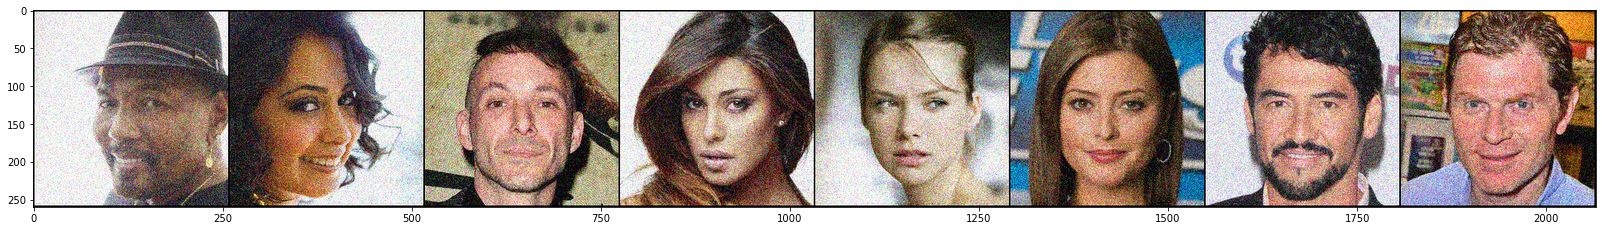

In [12]:
def gen_noise(images):
    noise = []
    ht, wd = len(images[0]), len(images[0][0])
    p, q, r, s = ht//10, ht//5, ht//3, ht//2
    
    for img in images:
        p, q, r, s = np.random.randint(10, 30), np.random.randint(10, 50), np.random.randint(50, 100), np.random.randint(100, 200)
        noise_image = np.copy(img)

        noise_img = random_noise(noise_image[p:p+s, q:wd-p], mode='s&p',amount=0.05)
        noise_image[p:p+s, q:wd-p] = np.array(255*noise_img, dtype = 'uint8')

        noise_img = random_noise(noise_image[q:ht-p, p:wd-r], mode='gaussian', var=0.02)
        noise_image[q:ht-p, p:wd-r] = np.array(255*noise_img, dtype = 'uint8')

        noise_img = random_noise(noise_image[r:q+s, q:q+s], mode='speckle', mean=0.1)
        noise_image[r:q+s, q:q+s] = np.array(255*noise_img, dtype = 'uint8')
        noise.append(noise_image)
    return noise

def gen_noise(images):
    noise = []
    for img in images:
        noise_img = random_noise(np.copy(img), mode='gaussian', var=0.02)
        noise_img = np.array(255*noise_img, dtype = 'uint8')
        noise.append(noise_img)
    return noise

def cvt_bgr_yuv(images):
    ys, us, vs = [],[],[]
    for img in images:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        y, u, v = cv2.split(img_yuv)
        ys.append(np.expand_dims(y, axis=2))
        us.append(np.expand_dims(u, axis=2))
        vs.append(np.expand_dims(v, axis=2))
    return np.array(ys, dtype=np.uint8), np.array(us, dtype=np.uint8), np.array(vs, dtype=np.uint8)

def cvt_yuv_bgr(y, u, v):
    images = []
    for i in range(len(y)):
        yuv = np.zeros((y.shape[1], y.shape[2], 3), dtype=np.uint8)
        yuv[:,:,0] = y[i,:,:,0]
        yuv[:,:,1] = u[i,:,:,0]
        yuv[:,:,2] = v[i,:,:,0]
        img = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
        images.append(img)
    return np.array(images, dtype=np.uint8)

#clear image: images
clear_images = load_celeb_images(cwd + 'example_data/train/train-r08-s-0000-of-0120.tfrecords')
clear_copy = np.array(clear_images)
noise_images = gen_noise(clear_images)
plot_image_grid(noise_images[10:18])

## Divide and Merge Images

In [13]:
BLOCK_SIZE = 16
NUM_BLOCK = 21
BLOCK_PER_IMAGE = NUM_BLOCK * NUM_BLOCK
OVERLAP = 4
WIDTH = len(clear_images[0][0])
HEIGHT = len(clear_images[0])
NUM_CLUSTER = 1
SHAPE = (BLOCK_SIZE, BLOCK_SIZE, 1)
BATCH_SIZE = max(10000, BLOCK_PER_IMAGE)

print(BLOCK_PER_IMAGE, SHAPE, WIDTH, HEIGHT)

clear_ys, clear_us, clear_vs = cvt_bgr_yuv(clear_images)
noise_ys, noise_us, noise_vs = cvt_bgr_yuv(noise_images)

441 (16, 16, 1) 256 256


In [14]:
def divide_img(img, block_size=18, num_block=18, overlap=4):
    height = len(img)
    width = len(img[0])
    if not (block_size*num_block - (num_block - 1)*overlap == height):
        raise ValueError('Block size mismatch', 
                          block_size*num_block - (num_block - 1)*overlap, height)
    size = block_size - overlap
    blocks = np.array([img[i:i+block_size, j:j+block_size] 
                      for j in range(0,width - overlap,size) 
                      for i in range(0,height - overlap,size)])
    return blocks

def merge_img(blocks, width=256, height=256, block_size=18, overlap=4):
    num_block_per_row = (width - overlap)//(block_size - overlap)
    num_block_per_col = (height - overlap)//(block_size - overlap)
    def get_row_block(row):
        row_block = blocks[row]
        for j in range(1, num_block_per_row):
            cur_row_block = row_block[:, :len(row_block[0]) - overlap]
            block1 = blocks[row+j*num_block_per_col]
            cur_block = block1[:, overlap:]
            lapping = row_block[:, len(row_block[0]) - overlap:]
            lapping1 = block1[:, :overlap]
            for k in range(0, overlap):
                lapping[:, k] *= 1 - (k+1)/(overlap+1)
                lapping1[:, k] *= (k+1)/(overlap+1)
            lap = lapping + lapping1
            row_block = np.concatenate([cur_row_block, lap, cur_block], axis=1)
        return row_block

    img = get_row_block(0)
    for i in range(1, num_block_per_col):
        cur_block = img[:len(img)-overlap]
        cur_row = get_row_block(i)
        lapping = img[len(img)-overlap:]
        lapping1 = cur_row[:overlap]
        cur_row = cur_row[overlap:]
        for k in range(0, overlap):
            lapping[k,:] *= 1 - (k+1)/(overlap+1)
            lapping1[k,:] *= (k+1)/(overlap+1)
        lap = lapping + lapping1
        img = np.concatenate([cur_block, lap, cur_row], axis=0)
    return img

def gen_train_set(clear_imgs, blur_imgs, shape, block_size, num_block, overlap):
    noise_images = np.expand_dims(np.zeros(shape), 0)
    clear_images = np.expand_dims(np.zeros(shape), 0)

    for i in range(len(clear_imgs)):
        blocks = divide_img(clear_imgs[i], block_size, num_block, overlap)
        clear_images = np.concatenate([clear_images, blocks])
        blur_blocks = divide_img(blur_imgs[i], block_size, num_block, overlap)
        noise_images = np.concatenate([noise_images, blur_blocks])
    return clear_images[1:]/255, noise_images[1:]/255

In [ ]:
clear_ys, noise_ys = gen_train_set(clear_ys, noise_ys, SHAPE, BLOCK_SIZE, NUM_BLOCK, OVERLAP)
clear_us, noise_us = gen_train_set(clear_us, noise_us, SHAPE, BLOCK_SIZE, NUM_BLOCK, OVERLAP)
clear_vs, noise_vs = gen_train_set(clear_vs, noise_vs, SHAPE, BLOCK_SIZE, NUM_BLOCK, OVERLAP)
print(noise_ys.shape, clear_ys.shape)

(132300, 16, 16, 1) (132300, 16, 16, 1)


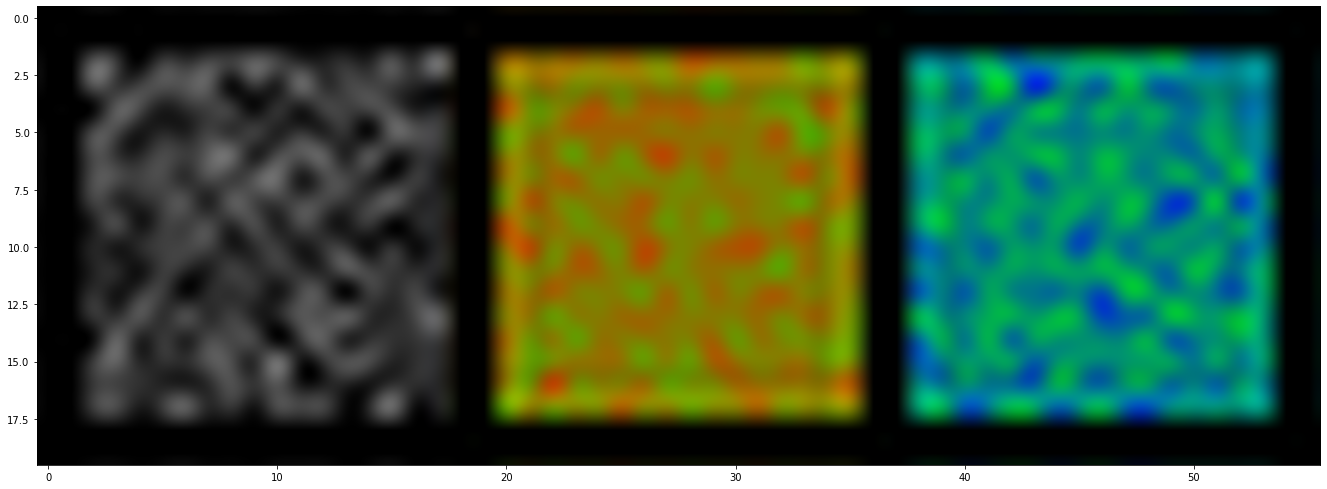

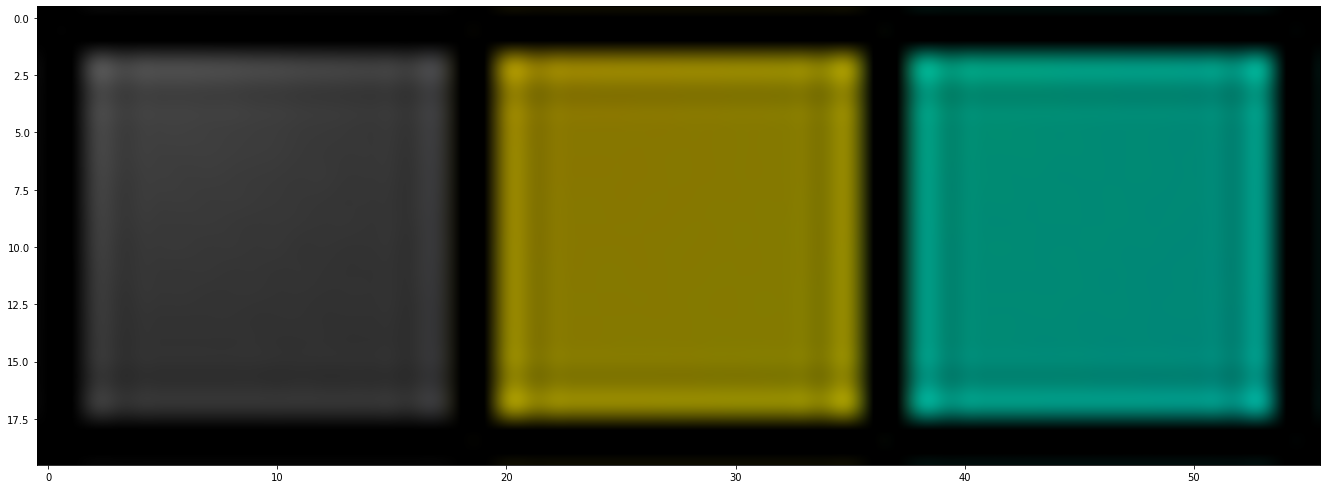

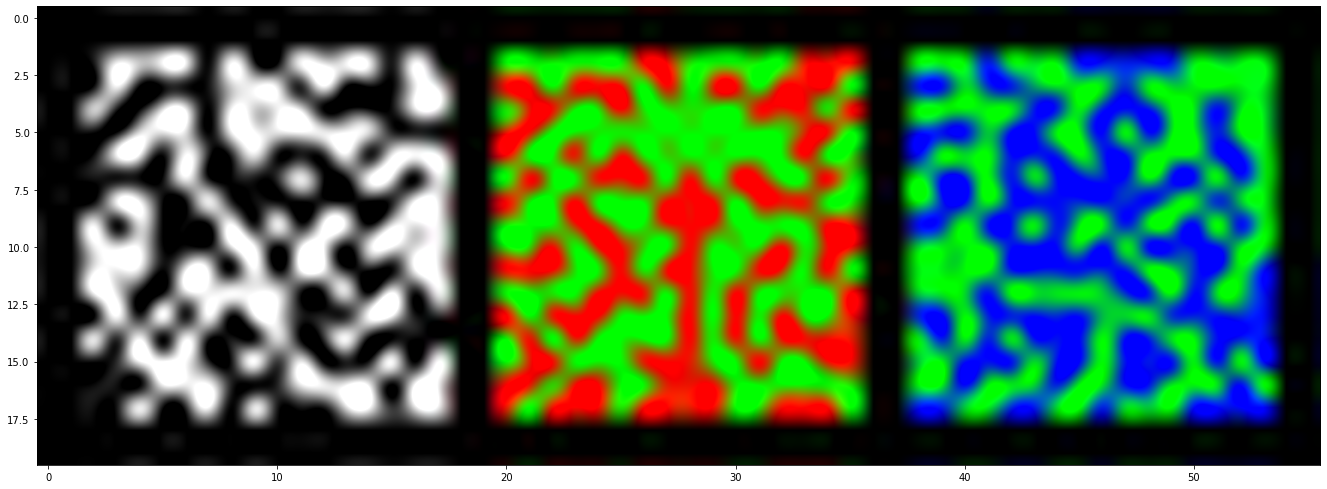

In [ ]:
def display_only_yuv(y, u, v):
    def make_lut_u():
        return np.array([[[i,255-i,0] for i in range(256)]],dtype=np.uint8)

    def make_lut_v():
        return np.array([[[0,255-i,i] for i in range(256)]],dtype=np.uint8)
    lut_u, lut_v = make_lut_u(), make_lut_v()

    # Convert back to BGR so we can apply the LUT and stack the images
    y = cv2.cvtColor(y, cv2.COLOR_GRAY2BGR)
    u = cv2.cvtColor(u, cv2.COLOR_GRAY2BGR)
    v = cv2.cvtColor(v, cv2.COLOR_GRAY2BGR)

    u_mapped = cv2.LUT(u, lut_u)
    v_mapped = cv2.LUT(v, lut_v)
    images = np.array([y, u_mapped, v_mapped])
    plot_image_grid(images, 4)

def display_patch_matching(noise_ys, noise_us, noise_vs, clear_ys, clear_us, clear_vs, k):
    yy = np.array(noise_ys[k]*255, dtype=np.uint8)
    uu = np.array(noise_us[k]*255, dtype=np.uint8)
    vv = np.array(noise_vs[k]*255, dtype=np.uint8)
    yc = np.array(clear_ys[k]*255, dtype=np.uint8)
    uc = np.array(clear_us[k]*255, dtype=np.uint8)
    vc = np.array(clear_vs[k]*255, dtype=np.uint8)
    y_ = np.array((noise_ys[k] - clear_ys[k])*255, dtype=np.uint8)
    u_ = np.array((noise_us[k] - clear_us[k])*255, dtype=np.uint8)
    v_ = np.array((noise_vs[k] - clear_vs[k])*255, dtype=np.uint8)
    display_only_yuv(yy, uu, vv)
    display_only_yuv(yc, uc, vc)
    display_only_yuv(y_, u_, v_)

for k in range(0,3000,400):
    display_patch_matching(noise_ys, noise_us, noise_vs, clear_ys, clear_us, clear_vs, k)
    break
    print()

## Model

In [15]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim), mean=0,stddev=0)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(latent_dim, shape):
    encoder_inputs = keras.Input(shape=shape)
    regularizer = keras.regularizers.l1_l2(0.01)
    x = layers.Conv2D(16, 3, activation="relu", strides=1, padding="same", 
                      kernel_regularizer=regularizer)(encoder_inputs)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same",
                      kernel_regularizer=regularizer)(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", 
                      kernel_regularizer=regularizer)(x)
    x = layers.Conv2D(72, 3, activation="relu", strides=1, padding="same",
                      kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)

    z = layers.Dense(latent_dim, name="z")(x)
    z_sig = layers.Dense(latent_dim, activation='softplus')(x)
    encoder = keras.Model(encoder_inputs, [z, z_sig], name="encoder")
    return encoder

def build_decoder(latent_dim, shape):
    latent_inputs = keras.Input(shape=(latent_dim,))
    regularizer = keras.regularizers.l1_l2(0.01)
    x = layers.Dense(shape[0] * shape[1] * 16, activation="relu",
                    kernel_regularizer=regularizer)(latent_inputs)
    x = layers.Reshape((shape[0]//4, shape[1]//4, 256))(x)
    x = layers.Conv2DTranspose(72, 3, activation="relu", strides=1,
                              kernel_regularizer=regularizer, padding="same")(x)
    x = layers.Conv2DTranspose(48, 3, activation="relu", strides=2,
                              kernel_regularizer=regularizer, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1,
                               kernel_regularizer=regularizer, padding="same")(x)
    x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, 
                              kernel_regularizer=regularizer, padding="same")(x)
    output = layers.Conv2DTranspose(3, 3, 
                                    activation="sigmoid", 
                                    kernel_regularizer=regularizer, 
                                    padding="same")(x)
    decoder = keras.Model(latent_inputs, output)
    return decoder

def build_transformation(latent_dim):
    model = Sequential()
    model.add(Dense(latent_dim, activation='relu', input_shape=(latent_dim,)))
    model.add(Dense(latent_dim, activation='relu'))
    model.add(Dense(latent_dim, activation='relu'))
    return model

class VAE(tf.keras.Model):
    def __init__(self, latent_dim, shape, encoder=None):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        if encoder==None:
            self.encoder = build_encoder(latent_dim, shape)
        self.transform = build_transformation(latent_dim)
        self.decoder = build_decoder(latent_dim, shape)
        self.sampling = Sampling()
        self.shape = shape

    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        z = self.transform(z)
        return self.decode(z)

    @tf.function
    def encode(self, x):
        mean, logvar = self.encoder(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        return self.sampling([mean, logvar])

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    def elbo_loss(self, z, mu, logvar, target):
        recons = self.decode(z)
        mse = tf.reduce_mean(tf.keras.losses.MSE(target, recons))
        mse *= self.shape[0] * self.shape[1]
        kld = -0.5 * tf.reduce_mean(1 + logvar - tf.math.pow(mu, 2) - tf.math.exp(logvar))
        return mse + kld

    def train_step(self, inputs):
        noise = inputs[0][0]
        clean = inputs[0][1]
        # data: [batch * height * width * channel], noise image
        # label: [batch * height * width * channel], clean image
        with tf.GradientTape(persistent=True) as tape:
            m_n, var_n = self.encode(noise)
            z_n = self.transform(self.reparameterize(m_n, var_n))
            m_c, var_c = self.encode(clean)
            z_c = self.reparameterize(m_c, var_c)
            latent_loss = tf.reduce_mean(tf.keras.losses.MSE(z_c, z_n))
            elbo_loss = self.elbo_loss(z_n, m_n, var_n, clean)

        tran_grads = tape.gradient(latent_loss, self.transform.trainable_weights)
        self.optimizer.apply_gradients(zip(tran_grads, self.transform.trainable_weights))

        vae_grads = tape.gradient(elbo_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(vae_grads, self.trainable_weights))
        return {
            "elbo_loss": elbo_loss,
            "latent_loss": latent_loss,
        }

In [16]:
def train_model(model, clear_images, noise_images, epoch=1, batch_size=128, lr=0.0001):
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))
    model.fit((noise_images,clear_images), epochs=epoch, batch_size=batch_size)
    return model

def plot_latent(encoder, blur_images):
    batch = 10000
    x,_ = encoder(blur_images[:batch])
    for i in range(batch, len(blur_images), batch):
        new_x,_ = encoder(blur_images[i: i+batch])
        x = np.concatenate([x, new_x], axis=0)

    pca =  decomposition.PCA(n_components=2)
    x = pca.fit_transform(x)
    colors = ['blue', 'red', 'green', 'black', 'yellow', 'purple']
    plt.scatter(x[:, 0], x[:, 1], s=5, c=colors[0])
    plt.show()

def plot_latent(encoder, noise, clean):
    batch = 10000
    x_n,_ = encoder(noise[:batch])
    x_c,_ = encoder(clean[:batch])
    for i in range(batch, len(noise), batch):
        new_x,_ = encoder(noise[i: i+batch])
        x_n = np.concatenate([x_n, new_x], axis=0)

        new_x,_ = encoder(clean[i: i+batch])
        x_c = np.concatenate([x_c, new_x], axis=0)
    pca =  manifold.TSNE(n_components=2)
    x_n = pca.fit_transform(x_n)
    x_c = pca.fit_transform(x_c)
    colors = ['blue', 'red', 'green', 'black', 'yellow', 'purple']
    plt.scatter(x_n[:, 0], x_n[:, 1], s=5, c=colors[0])
    plt.scatter(x_c[:, 0], x_c[:, 1], s=5, c=colors[1])
    plt.show()

def save_models(model, file_path):
    model.encoder.save(cwd + file_path + 'encoder')
    model.decoder.save(cwd + file_path + 'decoder')
    model.transform.save(cwd + file_path + 'transform')

def load_models(file_path, latent_dim, shape):
    encoder = keras.models.load_model(cwd + file_path + 'encoder')
    decoder = keras.models.load_model(cwd + file_path + 'decoder')
    transform = keras.models.load_model(cwd + file_path + 'transform')
    model = VAE(latent_dim, shape)
    model.encoder = encoder
    model.decoder = decoder
    model.transform = transform
    return model

LATENT_DIM = 72
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.95
)

In [ ]:
model_y = VAE(LATENT_DIM, SHAPE)
train_model(model_y, clear_ys, noise_ys, 50, lr=lr_schedule)
save_models(model_y, 'pretrained models/celeba_y_no/')

Epoch 1/50
1034/1034 [==============================] - 25s 13ms/step - elbo_loss: 2.0804 - latent_loss: 0.0370
Epoch 2/50
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.8049 - latent_loss: 0.0269
Epoch 3/50
1034/1034 [==============================] - 10s 10ms/step - elbo_loss: 0.7294 - latent_loss: 0.0220
Epoch 4/50
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.6648 - latent_loss: 0.0195
Epoch 5/50
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.5943 - latent_loss: 0.0193
Epoch 6/50
1034/1034 [==============================] - 10s 10ms/step - elbo_loss: 0.5472 - latent_loss: 0.0181
Epoch 7/50
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.5217 - latent_loss: 0.0159
Epoch 8/50
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.5099 - latent_loss: 0.0147
Epoch 9/50
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.4983 - latent_loss: 0.0135
Epoc

In [ ]:
model_u = VAE(LATENT_DIM, SHAPE)
train_model(model_u, clear_us, noise_us, 30, lr=lr_schedule)
save_models(model_u, 'pretrained models/celeba_u_no/')

Epoch 1/30
1034/1034 [==============================] - 13s 10ms/step - elbo_loss: 0.4837 - latent_loss: 0.0183
Epoch 2/30
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.0677 - latent_loss: 0.0039
Epoch 3/30
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.0562 - latent_loss: 0.0026
Epoch 4/30
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.0527 - latent_loss: 0.0022
Epoch 5/30
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.0520 - latent_loss: 0.0020
Epoch 6/30
1034/1034 [==============================] - 10s 9ms/step - elbo_loss: 0.0489 - latent_loss: 0.0019
Epoch 7/30
1034/1034 [==============================] - 10s 10ms/step - elbo_loss: 0.0459 - latent_loss: 0.0018
Epoch 8/30
1034/1034 [==============================] - 13s 12ms/step - elbo_loss: 0.0429 - latent_loss: 0.0017
Epoch 9/30
1034/1034 [==============================] - 10s 10ms/step - elbo_loss: 0.0408 - latent_loss: 0.0016
E

In [ ]:
model_v = VAE(LATENT_DIM, SHAPE)
train_model(model_v, clear_vs, noise_vs, 30, lr=lr_schedule)
save_models(model_v, 'pretrained models/celeba_v_no/')

Epoch 1/30
1034/1034 [==============================] - 11s 9ms/step - elbo_loss: 0.2507 - latent_loss: 0.0123
Epoch 2/30
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.0724 - latent_loss: 0.0037
Epoch 3/30
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.0672 - latent_loss: 0.0029
Epoch 4/30
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.0624 - latent_loss: 0.0025
Epoch 5/30
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.0599 - latent_loss: 0.0022
Epoch 6/30
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.0580 - latent_loss: 0.0020
Epoch 7/30
1034/1034 [==============================] - 13s 13ms/step - elbo_loss: 0.0565 - latent_loss: 0.0019
Epoch 8/30
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.0550 - latent_loss: 0.0018
Epoch 9/30
1034/1034 [==============================] - 9s 9ms/step - elbo_loss: 0.0546 - latent_loss: 0.0016
Epoch 1

In [ ]:
# plot_latent(model_y.encoder, noise_ys, clear_ys)
# plot_latent(model_u.encoder, noise_us, clear_us)
# plot_latent(model_v.encoder, noise_vs, clear_vs)

## Reconstruction

In [17]:
def reconstruct_image(noise_blocks, model, batch_size, block_per_image, width, height, block_size, overlap):
    recons_images = []
    decoded_images = model(noise_blocks[:batch_size])
    for i in range(batch_size, len(noise_blocks), batch_size):
        decoded_images = np.concatenate([decoded_images, 
                                         model(noise_blocks[i:i+batch_size])], 
                                        axis=0)
    blocks = decoded_images[: block_per_image]
    image = merge_img(blocks, width, height, block_size, overlap)
    recons_images = tf.convert_to_tensor([image], np.float32)
    for i in range(block_per_image, len(decoded_images), block_per_image):
        blocks = decoded_images[i: i+block_per_image]
        image = merge_img(blocks, width, height, block_size, overlap)
        recons_images = tf.concat([recons_images, tf.convert_to_tensor([image], np.float32)], axis=0)
    recons_images = tf.cast((recons_images*255), dtype=tf.uint8)
    return recons_images.numpy()

clear_images =  load_celeb_images(cwd + 'example_data/val/validation-r08-s-0000-of-0040.tfrecords')[:32]
clear_copy = np.array(clear_images)
noise_images = gen_noise(clear_images)
clear_ys, clear_us, clear_vs = cvt_bgr_yuv(clear_images)
noise_ys, noise_us, noise_vs = cvt_bgr_yuv(noise_images)

clear_ys, noise_ys = gen_train_set(clear_ys, noise_ys, SHAPE, BLOCK_SIZE, NUM_BLOCK, OVERLAP)
clear_us, noise_us = gen_train_set(clear_us, noise_us, SHAPE, BLOCK_SIZE, NUM_BLOCK, OVERLAP)
clear_vs, noise_vs = gen_train_set(clear_vs, noise_vs, SHAPE, BLOCK_SIZE, NUM_BLOCK, OVERLAP)

## Evaluation

In [18]:
def quality_evaluation(recons_images, test_images, metric='PSNR', display=True):
    recons = []
    for i in range(len(recons_images)):
        metric_recons = 0
        if metric == 'PSNR':
            metric_recons = cv2.PSNR(recons_images[i], test_images[i])
        elif metric == 'SSIM':
            metric_recons = ssim(recons_images[i], test_images[i], multichannel=True)
        elif metric == 'UQI':
            metric_recons = sewar.full_ref.uqi(recons_images[i], test_images[i], ws=8)
        recons.append(metric_recons)
    if display:
        print(metric)
        print(np.array(recons).mean())
    return np.array(recons).mean()

PSNR
28.84094765614841


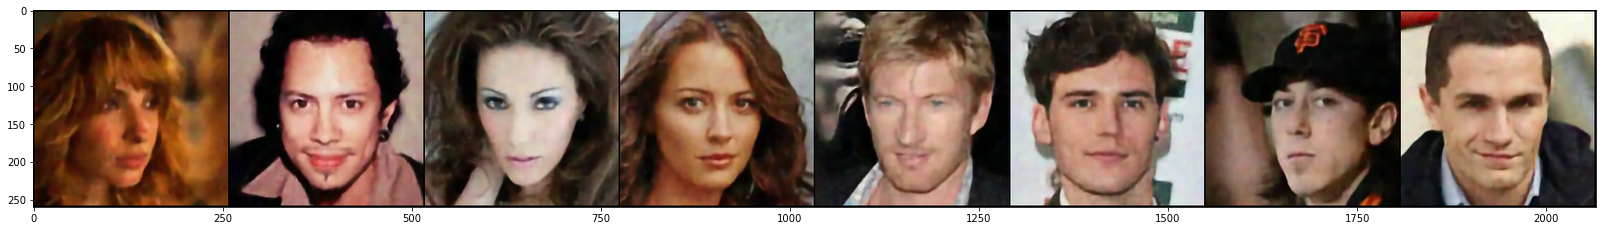

In [19]:
model_y = load_models('pretrained models/celeba_y_no/', LATENT_DIM, SHAPE)
model_u = load_models('pretrained models/celeba_u_no/', LATENT_DIM, SHAPE)
model_v = load_models('pretrained models/celeba_v_no/', LATENT_DIM, SHAPE)

recons_ys = reconstruct_image(noise_ys, model_y, BATCH_SIZE, BLOCK_PER_IMAGE, WIDTH, HEIGHT, BLOCK_SIZE, OVERLAP)
recons_us = reconstruct_image(noise_us, model_u, BATCH_SIZE, BLOCK_PER_IMAGE, WIDTH, HEIGHT, BLOCK_SIZE, OVERLAP)
recons_vs = reconstruct_image(noise_vs, model_v, BATCH_SIZE, BLOCK_PER_IMAGE, WIDTH, HEIGHT, BLOCK_SIZE, OVERLAP)

recons_images = cvt_yuv_bgr(recons_ys, recons_us, recons_vs)

quality_evaluation(recons_images, clear_copy)
plot_image_grid(recons_images[:8], 8)

## RL

In [1]:
import gym
from gym import spaces
from stable_baselines3 import A2C
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv

In [2]:
clear_images = [load_celeb_images(test_files[0]) for i in range(FILE_BATCH)]
clear_images = np.concatenate(clear_images, axis=0)[:32]
noise_images = np.array(gen_noise(clear_images))
WIDTH = len(clear_images[0])
HEIGHT = len(clear_images[0][0])
plot_image_grid(clear_images[8:16])
clear_images.shape, noise_images.shape

In [4]:
class Img_Enhancing_Env(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, clear_images, noise_images, models, target_score):
        super(Img_Enhancing_Env, self).__init__()
        self.clear_images = clear_images
        self.noise_images = noise_images
        self.test_images = np.array(clear_images)
        self.target_score = target_score

        self.init_weights = []
        for model in models:
            self.init_weights.append(model.transform.trainable_variables)
        self.models = models
        self.reward_range = (-15, 5)
        self.psnr = 0

        self.h = len(clear_images[0][0])
        self.current_step = 0
        self.action_space = spaces.Box(low=0.999, high=1.001, shape=(LATENT_DIM*3,), dtype=np.float32)
        self.observation_space = spaces.Box(0, self.target_score, shape=(1,),dtype=np.float32)
    
    def step(self, action):
        for k in range(len(self.init_weights)):
            for i in range(len(self.init_weights[k])):
                self.models[k].transform.trainable_variables[i].assign(tf.multiply(self.init_weights[k][i], 
                                                                       action[k*LATENT_DIM: (k+1)*LATENT_DIM]))
        
        clear_ys, clear_us, clear_vs = cvt_bgr_yuv(self.clear_images)
        noise_ys, noise_us, noise_vs = cvt_bgr_yuv(self.noise_images)
        
        clear_ys, noise_ys = gen_train_set(clear_ys, noise_ys, SHAPE, BLOCK_SIZE, NUM_BLOCK, OVERLAP)
        clear_us, noise_us = gen_train_set(clear_us, noise_us, SHAPE, BLOCK_SIZE, NUM_BLOCK, OVERLAP)
        clear_vs, noise_vs = gen_train_set(clear_vs, noise_vs, SHAPE, BLOCK_SIZE, NUM_BLOCK, OVERLAP)
        
        recons_ys = reconstruct_image(noise_ys, model_y, BATCH_SIZE, BLOCK_PER_IMAGE, WIDTH, HEIGHT, BLOCK_SIZE, OVERLAP)
        recons_us = reconstruct_image(noise_us, model_u, BATCH_SIZE, BLOCK_PER_IMAGE, WIDTH, HEIGHT, BLOCK_SIZE, OVERLAP)
        recons_vs = reconstruct_image(noise_vs, model_v, BATCH_SIZE, BLOCK_PER_IMAGE, WIDTH, HEIGHT, BLOCK_SIZE, OVERLAP)

        recons_images = cvt_yuv_bgr(recons_ys, recons_us, recons_vs)
        imshow(recons_images[9])

        psnr = quality_evaluation(recons_images, self.test_images, metric='PSNR', display=False)
        reward = 1.25 * (psnr - self.target_score) + 5
        reward = self.reward_range[1] if reward > self.reward_range[1] else reward
        reward = self.reward_range[0] if reward < self.reward_range[0] else reward
        done = psnr >= self.target_score - 1
        self.current_step += 1
        self.psnr = psnr
        print(self.current_step, reward, cv2.PSNR(clear_images[9], recons_images[9]))
        obs = np.array([psnr])
        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        print('reset')
        self.psnr = 0
        self.current_step = 0
        obs = np.array([0])
        return obs

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        print(f'Step: {self.current_step}')
        print(f'PSNR: {self.psnr}')

# model_y = load_models('pretrained models/celeba_y/', LATENT_DIM, SHAPE)
# model_u = load_models('pretrained models/celeba_u/', LATENT_DIM, SHAPE)
# model_v = load_models('pretrained models/celeba_v/', LATENT_DIM, SHAPE)
env = DummyVecEnv([lambda: Img_Enhancing_Env(clear_images, noise_images, [model_y, model_u, model_v], 30)])

Using cuda device
reset


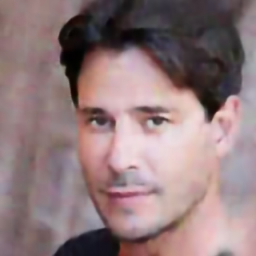

1 3.206181227550342 30.42203227985699


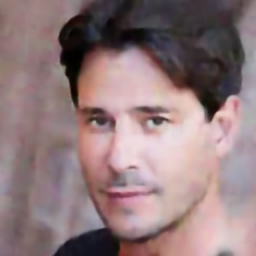

2 3.208866487544606 30.42520401345714


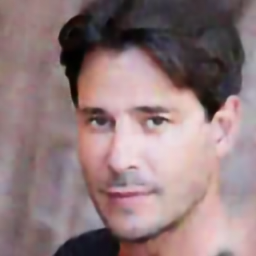

3 3.210447165403889 30.426356957709512


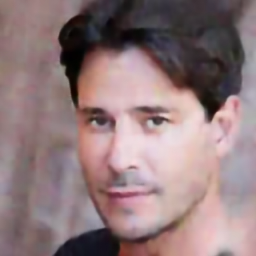

4 3.2075492886615065 30.424188836626094


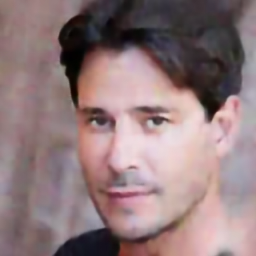

5 3.2024179154445953 30.419704295952165


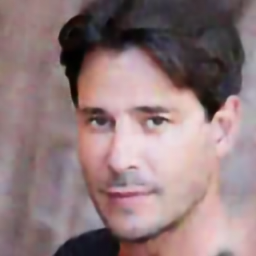

6 3.2085614173471333 30.426378318355603


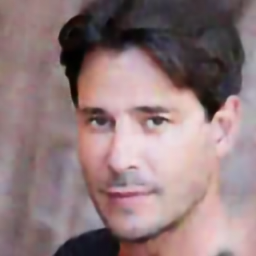

7 3.2136978343075695 30.430834871927075


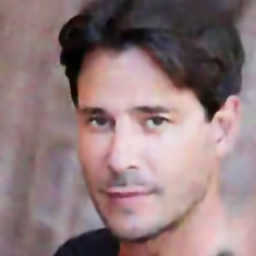

8 3.2116391421297408 30.427603545972808


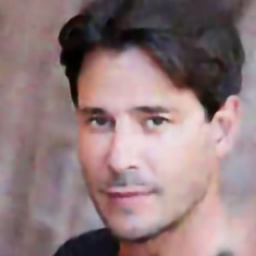

9 3.21043522881034 30.424472387967228


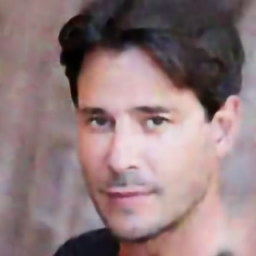

10 3.210555980670513 30.424440922968632


In [ ]:
rl_model = SAC('MlpPolicy', env, verbose=1, learning_rate=0.001)
rl_model.learn(total_timesteps=10)

Using cuda device
reset


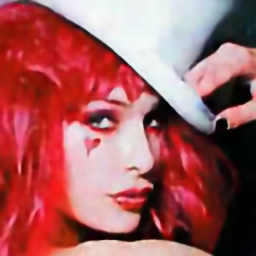

1 3.206065636331088 28.56485250906487


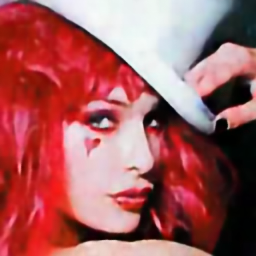

2 3.2104324762077674 28.568345980966214


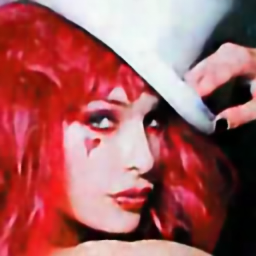

3 3.2078531515168196 28.566282521213456


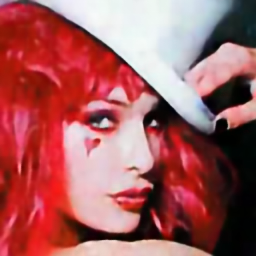

4 3.209434779902316 28.567547823921853


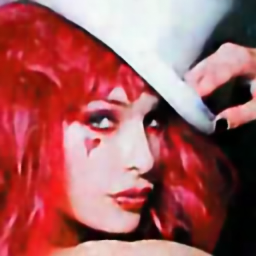

5 3.213065229618479 28.570452183694783


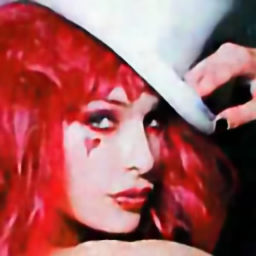

6 3.217199635453465 28.573759708362772


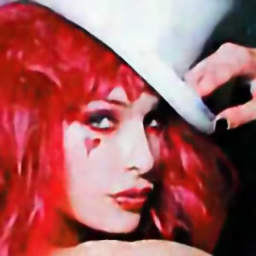

7 3.2131330183235285 28.570506414658823


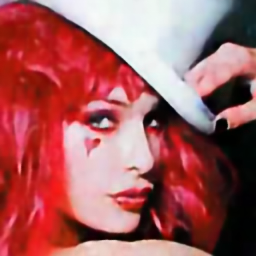

8 3.213359291589386 28.57068743327151


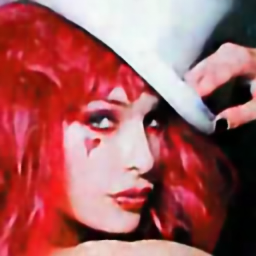

9 3.2134318219784053 28.570745457582724


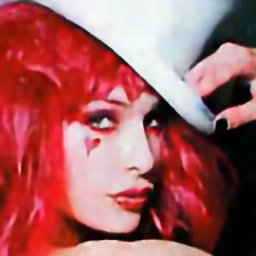

10 3.2191571492736992 28.57532571941896


In [ ]:
rl_model = SAC('MlpPolicy', env, verbose=1, learning_rate=0.001)
rl_model.learn(total_timesteps=10)